In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random

In [ ]:
rng = np.random.default_rng()

In [20]:
X_train = np.linspace(0, 2 * math.pi, 1000)
y_train = np.sin(X_train)
y_train += rng.standard_normal(size=(1000,)) * 0.1


In [3]:
X_test = np.linspace(0, 2*math.pi, 333)
y_test = np.sin(X_test)

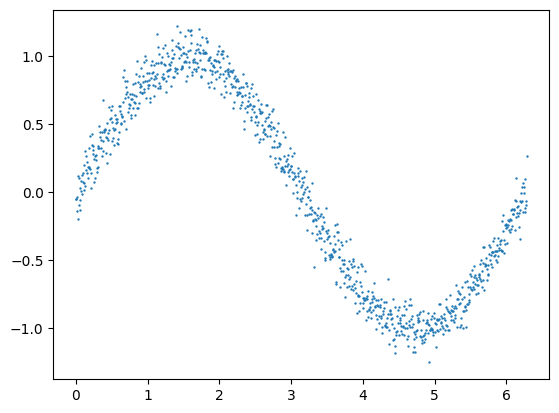

In [23]:
plt.scatter(X_train, y_train, s = 0.5)

In [24]:
def sigmoid(x):
    return 1 / (1 + np.exp(x * -1))

def relu(x):
    return x if x > 0 else 0

def relu_derivative(intermediate_value):
    return 1 if intermediate_value > 0 else 0

class Network():

    def __init__(self, layer_sizes, activation_function):
        self.layer_sizes = layer_sizes
        self.n_layers = len(layer_sizes)

        self.weights = [rng.standard_normal(size=(layer_sizes[i], layer_sizes[i-1])) for i in range(1,len(layer_sizes))]
        self.biases = [rng.standard_normal(size=(layer_sizes[i], 1)) for i in range(1,len(layer_sizes))]
        self.mt_weights = [np.zeros((layer_sizes[i], layer_sizes[i-1])) for i in range(1,len(layer_sizes))]
        self.mt_biases = [np.zeros((layer_sizes[i], 1)) for i in range(1,len(layer_sizes))]
        self.vt_weights = [np.zeros((layer_sizes[i], layer_sizes[i-1])) for i in range(1,len(layer_sizes))]
        self.vt_biases = [np.zeros((layer_sizes[i], 1)) for i in range(1,len(layer_sizes))]

        self.activation_function = activation_function


    def AdamOptimizer(self, t, beta1, beta2, nabla_weights, nabla_biases, epsilon):
        mt_weights = [beta1 * self.mt_weights[i] + (1 - beta1) * nabla_weights[i] for i in range(len(nabla_weights))]
        mt_biases = [beta1 * self.mt_biases[i] + (1 - beta1) * nabla_biases[i] for i in range(len(nabla_biases))]

        vt_weights = [beta2 * self.vt_weights[i] + (1 - beta2) * (nabla_weights[i] ** 2) for i in range(len(nabla_weights))]
        vt_biases = [beta2 * self.vt_biases[i] + (1 - beta2) * (nabla_biases[i] ** 2) for i in range(len(nabla_biases))]

        self.mt_weights = mt_weights
        self.mt_biases = mt_biases
        self.vt_weights = vt_weights
        self.vt_biases = vt_biases

        mt_weights_hat = [self.mt_weights[i] / (1 - (beta1 ** t)) for i in range(len(nabla_weights))]
        mt_biases_hat = [self.mt_biases[i] / (1 - (beta1 ** t)) for i in range(len(nabla_biases))]

        vt_weights_hat = [self.vt_weights[i] / (1 - (beta2 ** t)) for i in range(len(nabla_weights))]
        vt_biases_hat = [self.vt_biases[i] / (1 - (beta2 ** t)) for i in range(len(nabla_biases))]

        new_nabla_weights = [mt_weights_hat[i] / np.sqrt(vt_weights_hat[i] + epsilon) for i in range(len(nabla_weights))]
        new_nabla_biases = [mt_biases_hat[i] / np.sqrt(vt_biases_hat[i] + epsilon) for i in range(len(nabla_biases))]

        return new_nabla_weights, new_nabla_biases

    def feedforward(self, a):
        intermediate_values = []

        for i in range(self.n_layers-1):
            intermediate_values.append(a)
            a = np.dot(self.weights[i], a) + self.biases[i]

            if i != self.n_layers - 2:

                if self.activation_function == 'relu':
                    a = relu(a)

                if self.activation_function == 'linear':
                    a = a

                if self.activation_function == 'sigmoid':
                    a = sigmoid(a)

        return a, intermediate_values

    def train(self, X_train, y_train, epochs=10, lr=1e-7):
        t = 0
        for j in range(epochs):
            print('epoch: ', j)
            for i in range(len(X_train)):
                t = t + 1
                predicted, intermediate_values = self.feedforward(X_train[i])
                nabla_weights, nabla_biases = self.backpropagation(intermediate_values, y_train[i], predicted)
                self.update_parameters(nabla_weights, nabla_biases, lr, t)

            predicted, cost = self.evaluate(X_train, y_train)
            print('cost: ', np.mean(cost))

    def update_parameters(self, nabla_weights, nabla_biases, lr, t):
        new_nabla_weights, new_nabla_biases = self.AdamOptimizer(t, 0.9, 0.999, nabla_weights, nabla_biases, 1e-8)
        for i in range(len(nabla_weights)):
            # print(nabla_weights)
            self.weights[i] = self.weights[i] + new_nabla_weights[i] * lr
            self.biases[i] = self.biases[i] + new_nabla_biases[i] * lr

    def backpropagation(self, intermediate_values, y, predicted):
        nabla_weights = []
        nabla_biases = []
        nabla_cost = 2 * (y - predicted)
        # print('nabla_cost: ', nabla_cost)
        curr_intermediate = nabla_cost

        # calculating partial derivative of cost with respect to weights and biases
        for i in range(1, self.n_layers):
            layer_idx = self.n_layers - 1 - i

            curr_layer_nabla_weights = np.dot(curr_intermediate, np.transpose(intermediate_values[layer_idx]))
            # print('layer idx: ', layer_idx)
            # print('curr_intermediate: ', curr_intermediate)
            # print('transpose of intermediate value: ', np.transpose(intermediate_values[layer_idx]))
            # print('curr nabla weights: ', curr_layer_nabla_weights)
            curr_layer_nabla_biases = curr_intermediate
            nabla_weights.insert(0,curr_layer_nabla_weights)
            nabla_biases.insert(0,curr_layer_nabla_biases)

            if self.activation_function == 'relu':
                derivative_multiplier = relu_derivative_vectorized(intermediate_values[layer_idx])

            if self.activation_function == 'linear':
                derivative_multiplier = 1

            if self.activation_function == 'sigmoid':
                derivative_multiplier = (intermediate_values[layer_idx] * (1 - intermediate_values[layer_idx]))

            curr_intermediate = np.dot(np.transpose(self.weights[layer_idx]), curr_intermediate) * derivative_multiplier


        # print('nabla weights: ', nabla_weights)
        return nabla_weights, nabla_biases

    def evaluate(self, X_data, y_data):
        predicted = []
        for i in range(len(X_data)):
            a, intermediate_values = self.feedforward(X_data[i])
            predicted.append(a)

        # print(predicted)

        predicted = np.asarray(predicted).reshape((len(X_data),))
        cost = (predicted - y_data) ** 2
        return predicted, cost



In [25]:
model = Network([1, 3, 3, 1], 'sigmoid')
predicted, cost = model.evaluate(X_test, y_test)
print('cost: ', np.mean(cost))


cost:  0.5179760794725753


In [ ]:
model.train(X_train, y_train, epochs=10000, lr=1e-4)
predicted, cost = model.evaluate(X_test, y_test)

In [27]:
predicted, cost = model.evaluate(X_test, y_test)

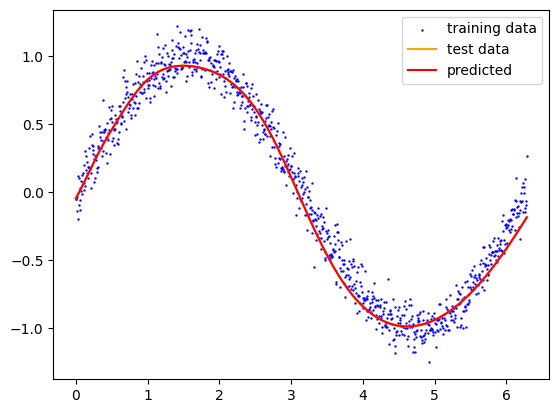

In [33]:
plt.scatter(X_train, y_train, label = 'training data', s = 0.5, color = 'blue')
plt.plot(X_test, predicted, label = 'test data', color = 'orange')
plt.plot(X_test, predicted, label = 'predicted', color = 'red')
plt.legend()